In [23]:
from graph_transformer import GraphTransformer
import torch
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt

In [24]:
dataset = Planetoid(root='data', name='Cora')
data = dataset[0]

In [25]:
x = data.x
adj = torch.zeros(data.num_nodes, data.num_nodes)
adj[data.edge_index[0], data.edge_index[1]] = 1

In [26]:
y = data.y
train_mask = data.train_mask
test_mask = data.test_mask
val_mask = data.val_mask

In [27]:
model = GraphTransformer(
    input_features=x.size(1),
    hidden_features=64,
    output_features=dataset.num_classes,
    num_edge_types=2,
    num_metachannels=3,
    num_layers=3,
    heads=4,
    dropout=0.1,
    pos_enc_dim=32
)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [29]:
edge_index_list = [data.edge_index]
edge_index_list

[tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
         [   0,    0,    0,  ..., 2707, 2707, 2707]])]

In [30]:
train_losses = []

for epoch in range(10):
    model.train()
    out, _, _ = model(x, edge_index_list)
    loss = loss_fn(out[data.train_mask], y[data.train_mask])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.9858
Epoch 1, Loss: 1.6157
Epoch 2, Loss: 1.1352
Epoch 3, Loss: 0.7487
Epoch 4, Loss: 0.3636
Epoch 5, Loss: 0.1982
Epoch 6, Loss: 0.0874
Epoch 7, Loss: 0.0332
Epoch 8, Loss: 0.0183
Epoch 9, Loss: 0.0107


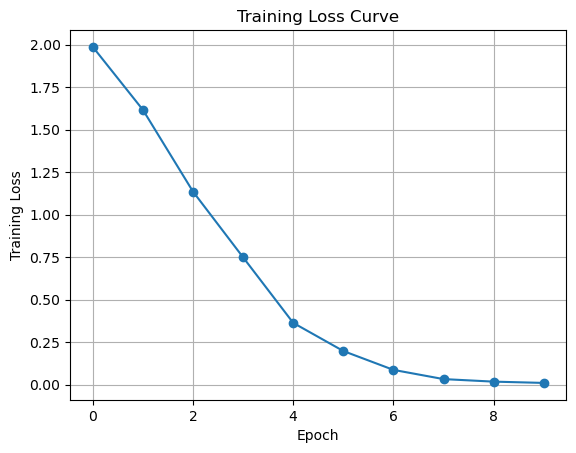

In [31]:
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [32]:
torch.save(model.state_dict(), "graph_transformer_model.pth")

In [33]:
model.load_state_dict(torch.load("graph_transformer_model.pth"))
model.eval()

GraphTransformer(
  (metapath): MetaPathLearner()
  (input_proj): Linear(in_features=1465, out_features=64, bias=True)
  (layers): ModuleList(
    (0-2): 3 x GraphTransformerLayer(
      (attn): GraphAttentionLayer(
        (q_proj): Linear(in_features=64, out_features=64, bias=False)
        (k_proj): Linear(in_features=64, out_features=64, bias=False)
        (v_proj): Linear(in_features=64, out_features=64, bias=False)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=64, out_features=64, bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=192, out_f

In [34]:
with torch.no_grad():
    out, _, _ = model(x, edge_index_list)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == y[data.test_mask]).sum().item()
    total = data.test_mask.sum().item()
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.6900
